This program uses Pyspark SQL to extract customer, branch and card data from the provided json file.

In [3]:
# Import libraries 
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import *
import pyspark.sql.functions as f
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests


# 1. Functional Requirements - Load Credit Card Database (SQL)

# Req-1.1 Data Extraction and Transformation with Python and PySpark

<b>Data Extraction and Transformation with Python and PySpark. </b><br>
For “Credit Card System,” create a Python and PySpark SQL program to read/extract the following JSON files according to the specifications found in the mapping document.

In [4]:
# Application to create Dataframes from source
spark = SparkSession.builder.master('local[1]').appName('CreditCardSystems').getOrCreate() 

# Extract the JSON files branch, credit and customer into a dataframe
df_branch = spark.read.json('cdw_sapp_branch.json')  
df_credit = spark.read.json('cdw_sapp_credit.json') 
df_customer = spark.read.json('cdw_sapp_customer.json')

# Register the DataFrame as a SQL temporary view
df_credit.createOrReplaceTempView("credit")
df_customer.createOrReplaceTempView("customer")
df_branch.createOrReplaceTempView("branch")

<b> Transform the data based on the requirements found in the Mapping Document

In [3]:
# Adjust customer table acording to the mapping document 
# Convert first and last name to Title Case and middle name to lower case
df_customer = df_customer.withColumn("FIRST_NAME", f.initcap(df_customer["FIRST_NAME"]))
df_customer = df_customer.withColumn("MIDDLE_NAME", f.lower(df_customer.MIDDLE_NAME))
df_customer = df_customer.withColumn("LAST_NAME", f.initcap(df_customer["LAST_NAME"]))
df_customer.select("FIRST_NAME", "MIDDLE_NAME","LAST_NAME").show()


+----------+-----------+---------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|
+----------+-----------+---------+
|      Alec|         wm|   Hooper|
|      Etta|    brendan|   Holman|
|    Wilber|   ezequiel|   Dunham|
|   Eugenio|      trina|    Hardy|
|   Wilfred|        may|    Ayers|
|      Beau|    ambrose|  Woodard|
|    Sheila|      larry|     Kemp|
|     Wendy|        ora|   Hurley|
|      Alec|     tracie|  Gilmore|
|    Barbra|    mitchel|      Lau|
|   Edmundo|      denny|  Thomson|
|      Elsa|   isabelle|   Truong|
|     Homer|      henry| Mckinney|
|      Rita|     rickey|     Kidd|
|    Amalia|  heriberto|  Ballard|
|     Patty|   angelita|   Thomas|
|  Josefina|   dorothea|   Morrow|
|    Nelson|  jefferson|  Andrews|
|    Miquel|     maximo|Schneider|
|    Parker|    arnulfo|  Tidwell|
+----------+-----------+---------+
only showing top 20 rows



In [4]:
# In customer table Concatenate Apartment no and Street name of customer's Residence with comma as a seperator (Street, Apartment)
df_customer = df_customer.select("FIRST_NAME","MIDDLE_NAME","LAST_NAME","SSN","CREDIT_CARD_NO","CUST_EMAIL","CUST_PHONE","CUST_CITY","CUST_STATE","CUST_ZIP","CUST_COUNTRY","LAST_UPDATED", f.concat_ws(",",df_customer.STREET_NAME,df_customer.APT_NO).alias("FULL_STREET_ADDRESS"))


In [5]:
# In th credit card table convert DAY, MONTH, and YEAR into a TIMEID (YYYYMMDD)
df_credit = df_credit.select("BRANCH_CODE","CREDIT_CARD_NO","CUST_SSN","TRANSACTION_ID","TRANSACTION_TYPE","TRANSACTION_VALUE",f.concat_ws(",",df_credit.YEAR,df_credit.MONTH,df_credit.DAY).alias("TIMEID"))

# Req-1.2 Data loading into Database
Once PySpark reads data from JSON files, and then utilizes Python, PySpark, and Python modules to load data into RDBMS(SQL), perform
the following: <br>
a) Create a Database in SQL(MariaDB), named “creditcard_capstone.” <br>
b) Create a Python and Pyspark Program to load/write the “Credit Card System Data” into RDBMS(creditcard_capstone). <br>
Tables should be created by the following names in RDBMS: <br>
CDW_SAPP_BRANCH <br>
CDW_SAPP_CREDIT_CARD <br>
CDW_SAPP_CUSTOMER <br>

In [6]:
# Create the table CDW_SAPP_BRANCH 
df_branch.write.format("jdbc") \
.mode("append") \
.option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
.option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
.option("user", "root") \
.option("password", "a") \
.save()

In [7]:
# Create the table CDW_SAPP_CREDIT_CARD 
df_credit.write.format("jdbc") \
.mode("append") \
.option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
.option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
.option("user", "root") \
.option("password", "a") \
.save()

In [8]:
# Create the table CDW_SAPP_CUSTOMER 
df_customer.write.format("jdbc") \
.mode("append") \
.option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
.option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
.option("user", "root") \
.option("password", "a") \
.save()

# 2. Functional Requirements - Application Front-End
Once data is loaded into the database, we need a front-end (console) to see/display data. For that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2).

<b> Req-2.1 Transaction Details Module </b><br>

# 2.1.1 Display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order

In [11]:
# 
def customer_transactions(Month, Year, Zipcode):
    sel = "SELECT customer.CUST_ZIP, credit.DAY, credit.MONTH, credit.YEAR, credit.TRANSACTION_TYPE, credit.TRANSACTION_VALUE"
    frm = " FROM credit, customer"
    where = f" WHERE credit.YEAR = {str(Year)} AND credit.MONTH = {str(Month)} AND customer.CUST_ZIP = {str(Zipcode)}"
    ordr = " ORDER BY credit.DAY DESC" # Order by ascending 

    sqlCredit = spark.sql(sel + frm + where + ordr)
    sqlCredit.show(20)

customer_transactions(8, 2018, 39120)

+--------+---+-----+----+----------------+-----------------+
|CUST_ZIP|DAY|MONTH|YEAR|TRANSACTION_TYPE|TRANSACTION_VALUE|
+--------+---+-----+----+----------------+-----------------+
|   39120| 28|    8|2018|           Bills|            23.57|
|   39120| 28|    8|2018|            Test|             24.6|
|   39120| 28|    8|2018|           Bills|            23.57|
|   39120| 28|    8|2018|   Entertainment|            46.53|
|   39120| 28|    8|2018|           Bills|            23.57|
|   39120| 28|    8|2018|   Entertainment|            46.53|
|   39120| 28|    8|2018|           Bills|            23.57|
|   39120| 28|    8|2018|   Entertainment|            46.53|
|   39120| 28|    8|2018|           Bills|            23.57|
|   39120| 28|    8|2018|   Entertainment|            46.53|
|   39120| 28|    8|2018|           Bills|            23.57|
|   39120| 28|    8|2018|             Gas|            11.02|
|   39120| 28|    8|2018|            Test|             24.6|
|   39120| 28|    8|2018

# 2.1.2 Display the number and total values of transactions for a given type

In [17]:
# 
def total_type_transactions(transact_type):
    sel = "SELECT COUNT(TRANSACTION_TYPE) as "+ transact_type + ", SUM(TRANSACTION_VALUE) as Total"
    frm = " FROM credit"
    where = f" WHERE TRANSACTION_TYPE = '{transact_type}'"
    sqlCredit = spark.sql(sel + frm + where)
    sqlCredit.show(20)

total_type_transactions("Bills")

+-----+----------------+
|Bills|           Total|
+-----+----------------+
| 6861|351405.280000001|
+-----+----------------+



# 2.1.3 Display the number and total values of transactions for branches in a given state

In [14]:

def total_branch_transactions(state):
    sel = "SELECT COUNT(branch.BRANCH_STATE), SUM(credit.TRANSACTION_VALUE) as Total"
    frm = " FROM branch, credit"
    where = f" WHERE branch.BRANCH_CODE = credit.BRANCH_CODE and branch.BRANCH_STATE = '{state}' "
    sql_branch = spark.sql(sel + frm + where)
    sql_branch.show(20)

total_branch_transactions("NY")

+-------------------+------------------+
|count(BRANCH_STATE)|             Total|
+-------------------+------------------+
|               4143|213717.38000000018|
+-------------------+------------------+



<b>Req-2.2 Customer Details </b><br>
1) Used to check the existing account details of a customer.<br>
2) Used to modify the existing account details of a customer.<br>
3) Used to generate a monthly bill for a credit card number for a given month and year. <br>
4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order. <br>

# 2.2.1 Check the existing account details of a customer


In [22]:
#
def customer_details(first_name, last_name):
    sel = "SELECT APT_NO, CREDIT_CARD_NO, CUST_CITY, CUST_COUNTRY, CUST_EMAIL, CUST_PHONE, CUST_STATE, CUST_ZIP"
    frm = " FROM customer"
    where = f" WHERE FIRST_NAME = '{first_name}' AND LAST_NAME = '{last_name}'"
    sqlCredit = spark.sql(sel + frm + where)
    sqlCredit.show(20)

customer_details("Alec", "Hooper")

+------+----------------+---------+-------------+-------------------+----------+----------+--------+
|APT_NO|  CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|
+------+----------------+---------+-------------+-------------------+----------+----------+--------+
|   656|4210653310061055|  Natchez|United States|AHooper@example.com|   1237818|        MS|   39120|
+------+----------------+---------+-------------+-------------------+----------+----------+--------+



# 2.2.2 Modify the exsiting account details of a customer


In [ ]:
# ALTER DATABASE inventory SET DBPROPERTIES ('Edited-by' = 'John', 'Edit-date' = '01/01/2001');

# 2.2.3 Generate a monthly bill for a credit card number for a given month and year


In [44]:
def monthly_bill(month, year, card_number):
    sel = "SELECT CREDIT_CARD_NO, YEAR, MONTH, TRANSACTION_VALUE"
    frm = " FROM credit"
    where = f" WHERE CREDIT_CARD_NO = 4210653349028689 AND MONTH = 8 AND YEAR = 2018" 
    grp_by = " GROUP BY CREDIT_CARD_NO"

    sql_bill = spark.sql(sel + frm + where + grp_by)
    sql_bill.show()

monthly_bill(8, 2018, 4210653349028689)

AnalysisException: expression 'credit.YEAR' is neither present in the group by, nor is it an aggregate function. Add to group by or wrap in first() (or first_value) if you don't care which value you get.;
Aggregate [CREDIT_CARD_NO#33], [CREDIT_CARD_NO#33, YEAR#40L, MONTH#36L, TRANSACTION_VALUE#39]
+- Filter (((cast(CREDIT_CARD_NO#33 as bigint) = 4210653349028689) AND (MONTH#36L = cast(8 as bigint))) AND (YEAR#40L = cast(2018 as bigint)))
   +- SubqueryAlias credit
      +- View (`credit`, [BRANCH_CODE#32L,CREDIT_CARD_NO#33,CUST_SSN#34L,DAY#35L,MONTH#36L,TRANSACTION_ID#37L,TRANSACTION_TYPE#38,TRANSACTION_VALUE#39,YEAR#40L])
         +- Relation [BRANCH_CODE#32L,CREDIT_CARD_NO#33,CUST_SSN#34L,DAY#35L,MONTH#36L,TRANSACTION_ID#37L,TRANSACTION_TYPE#38,TRANSACTION_VALUE#39,YEAR#40L] json


# 2.2.4 Display the transactions made by a customer between two date. Order by year, month, and day in desc. 

In [47]:

def transaction_between_dates(day_1, day_2):
    sel = "SELECT YEAR, MONTH, DAY, TRANSACTION_VALUE"
    frm = " FROM credit"
    where = f" WHERE DAY BETWEEN {str(day_1)} AND {str(day_2)}" 
    ordr_by = " ORDER BY YEAR, MONTH, DAY DESC"

    sql_two_date = spark.sql(sel + frm + where + ordr_by )
    sql_two_date.show()

transaction_between_dates(8, 14)

+----+-----+---+-----------------+
|YEAR|MONTH|DAY|TRANSACTION_VALUE|
+----+-----+---+-----------------+
|2018|    1| 14|            58.51|
|2018|    1| 14|             11.4|
|2018|    1| 14|            48.95|
|2018|    1| 14|            46.37|
|2018|    1| 14|            39.21|
|2018|    1| 14|            95.06|
|2018|    1| 14|            64.55|
|2018|    1| 14|            88.94|
|2018|    1| 14|            39.51|
|2018|    1| 14|            20.32|
|2018|    1| 14|            34.55|
|2018|    1| 14|            30.11|
|2018|    1| 14|            68.22|
|2018|    1| 14|            66.97|
|2018|    1| 14|            25.66|
|2018|    1| 14|             7.76|
|2018|    1| 14|            73.21|
|2018|    1| 14|            99.64|
|2018|    1| 14|            86.12|
|2018|    1| 14|            34.51|
+----+-----+---+-----------------+
only showing top 20 rows



# 3 - Functional Requirements - Data analysis and Visualization

After data is loaded into the database, users can make changes from the front end, and they can also view data from the front end. Now, the business analyst team wants to analyze and visualize the data according to the below requirements.


# 3.1 Find and plot which transaction type has a high rate of transactions

In [5]:
# Convert pyspark dataframe into pandas dataframe
df_credit_pd = df_credit.toPandas()
df_credit_pd

df_customer_pd = df_customer.toPandas()
df_customer_pd

df_branch_pd = df_branch.toPandas()
df_branch_pd


,BRANCH_CITY,BRANCH_CODE,BRANCH_NAME,BRANCH_PHONE,BRANCH_STATE,BRANCH_STREET,BRANCH_ZIP,LAST_UPDATED
0,Lakeville,1,Example Bank,1234565276,MN,Bridle Court,55044,2018-04-18T16:51:47.000-04:00
1,Huntley,2,Example Bank,1234618993,IL,Washington Street,60142,2018-04-18T16:51:47.000-04:00
2,SouthRichmondHill,3,Example Bank,1234985926,NY,Warren Street,11419,2018-04-18T16:51:47.000-04:00
3,Middleburg,4,Example Bank,1234663064,FL,Cleveland Street,32068,2018-04-18T16:51:47.000-04:00
4,KingOfPrussia,5,Example Bank,1234849701,PA,14th Street,19406,2018-04-18T16:51:47.000-04:00
...,...,...,...,...,...,...,...,...
110,Baldwin,178,Example Bank,1234612707,NY,8th Street West,11510,2018-04-18T16:51:47.000-04:00
111,NewHaven,180,Example Bank,1234347181,CT,Meadow Street,6511,2018-04-18T16:51:47.000-04:00
112,Quincy,188,Example Bank,1234259065,MA,Lincoln Avenue,2169,2018-04-18T16:51:47.000-04:00
113,Lititz,192,Example Bank,1234937904,PA,Glenwood Drive,17543,2018-04-18T16:51:47.000-04:00


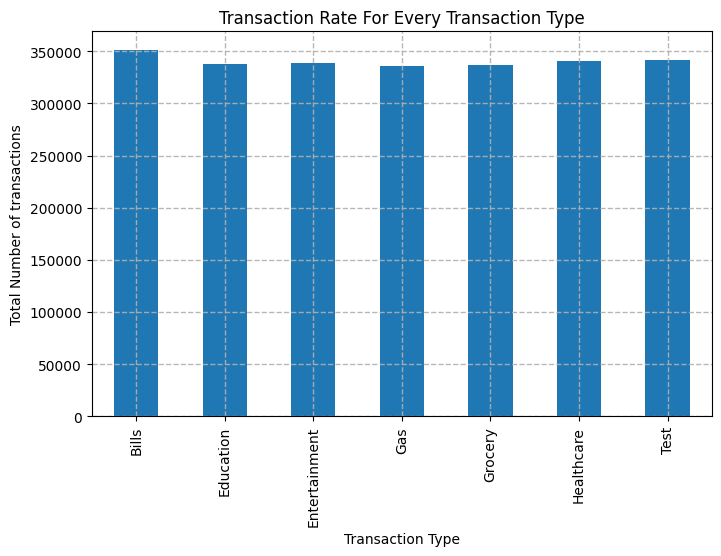

In [10]:
# Bargraph 
# x = transaction type 
# y = transaction values 

df_transact = df_credit_pd[['TRANSACTION_TYPE','TRANSACTION_VALUE']]
df_transact = df_transact.groupby(['TRANSACTION_TYPE'])['TRANSACTION_VALUE'].sum()

df_transact.plot(kind='bar', figsize=(8, 5))

plt.xlabel('Transaction Type')                              # add x-label to the plot
plt.ylabel('Total Number of transactions')                  # add y-label to the plot
plt.title('Transaction Rate For Every Transaction Type')    # add title to the plot
plt.grid(which='major',linestyle = '--', linewidth = 1, alpha=0.9)
plt.show()



# 3.2 Find and plot which state has a high number of customers

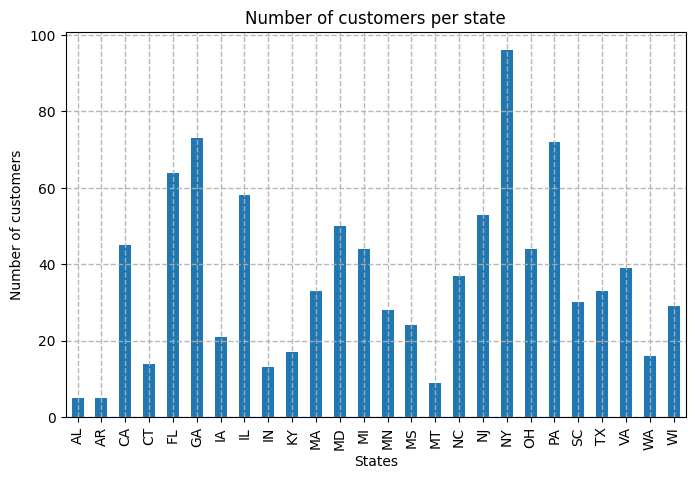

In [11]:
# x = all the states 
# y = number of customerws 
df_state = df_customer_pd[['CUST_STATE', 'SSN']]
df_state = df_state.groupby(['CUST_STATE'])['SSN'].count()
df_state.plot(kind='bar', figsize=(8, 5))

plt.xlabel('States')                          # add x-label to the plot
plt.ylabel('Number of customers')             # add y-label to the plot
plt.title('Number of customers per state')    # add title to the plot
plt.grid(which='major',linestyle = '--', linewidth = 1, alpha=0.9)
plt.show()

# 3.3 Find and plot the sum of all transactions for each customer, and which customer has the highest transaction amount.(First 20) hint(use CUST_SSN)



In [16]:
# x = customer
# y = transactions

df_all_transact = df_credit_pd[['CUST_SSN', 'TRANSACTION_VALUE']]
df_all_transact = df_all_transact.groupby(['CUST_SSN'])['TRANSACTION_VALUE'].sum()
df_all_transact = df_all_transact.head(20) # Get the first 20 results

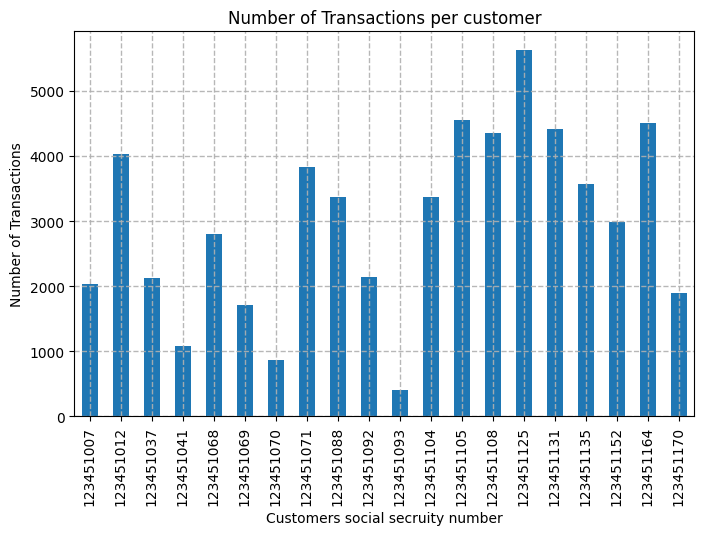

In [17]:

df_all_transact.plot(kind='bar', figsize=(8, 5))

plt.xlabel('Customers social secruity number')      # add x-label to the plot
plt.ylabel('Number of Transactions')                # add y-label to the plot
plt.title('Number of Transactions per customer')    # add title to the plot
plt.grid(which='major',linestyle = '--', linewidth = 1, alpha=0.9)
plt.show()

# 3.4 Find and plot the top three months with the largest transaction data


In [24]:
# x = months
# y = transaction value

df_top_three = df_credit_pd.nlargest(3, columns=['MONTH','TRANSACTION_VALUE'])
df_top_three = df_top_three[['MONTH','TRANSACTION_VALUE']]
df_top_three

,MONTH,TRANSACTION_VALUE
44153,12,100.98
30857,12,100.97
39039,12,100.94


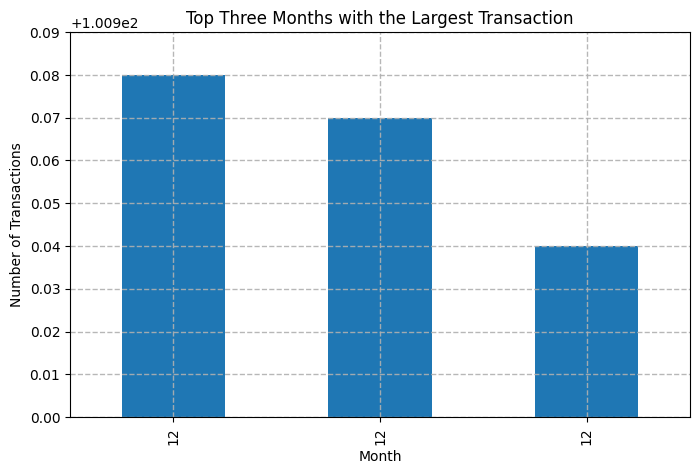

In [28]:

df_top_three.plot(kind='bar', x='MONTH', figsize=(8, 5), legend=None)
plt.xlabel('Month')                                             # add x-label to the plot
plt.ylabel('Number of Transactions')                            # add y-label to the plot
plt.title('Top Three Months with the Largest Transaction')      # add title to the plot
plt.grid(which='major',linestyle = '--', linewidth = 1, alpha=0.9)
plt.ylim(100.90,100.99)
plt.show()


# 3.5 Find and plot each branches healthcare transactions, showing which branch  processed the highest total dollar value of healthcare transactions

In [43]:
# x = branches 
# y = transactions
branch_health = df_credit_pd[['BRANCH_CODE','TRANSACTION_TYPE','TRANSACTION_VALUE']]
df_health= branch_health.groupby(['TRANSACTION_TYPE','BRANCH_CODE'])['TRANSACTION_VALUE'].sum()
df_health

TRANSACTION_TYPE  BRANCH_CODE
Bills             1              3162.86
                  2              2947.23
                  3              3475.58
                  4              3034.62
                  5              3748.60
                                  ...   
Test              175            2897.50
                  178            2720.72
                  180            3322.73
                  188            3132.79
                  192            2864.37
Name: TRANSACTION_VALUE, Length: 798, dtype: float64

In [44]:
df_health = df_health["Healthcare"]
df_health = df_health.to_frame()
df_health = df_health.head(20)

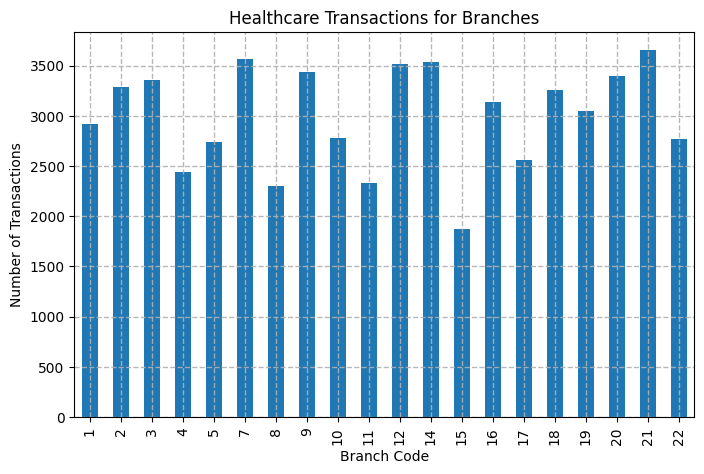

In [48]:
df_health.plot(kind='bar', figsize=(8, 5), legend=None)
plt.xlabel('Branch Code')                                             # add x-label to the plot
plt.ylabel('Number of Transactions')                            # add y-label to the plot
plt.title('Healthcare Transactions for Branches')      # add title to the plot
plt.grid(which='major',linestyle = '--', linewidth = 1, alpha=0.9)
plt.show()

# 4. Functional Requirements - LOAN Application Dataset

# 4.1 Create a Python program to GET (consume) data from the above API endpoint for the loan application dataset

In [93]:
url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
r = requests.get(url)
data = r.json()
data

[{'Application_ID': 'LP001002',
  'Gender': 'Male',
  'Married': 'No',
  'Dependents': '0',
  'Education': 'Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'medium',
  'Application_Status': 'Y'},
 {'Application_ID': 'LP001003',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '1',
  'Education': 'Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Rural',
  'Income': 'medium',
  'Application_Status': 'N'},
 {'Application_ID': 'LP001005',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '0',
  'Education': 'Graduate',
  'Self_Employed': 'Yes',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'low',
  'Application_Status': 'Y'},
 {'Application_ID': 'LP001006',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '0',
  'Education': 'Not Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'low',
  'Application_Status': 'Y'},
 {'Applica

# 4.2 Find the status code of the above API endpoint


In [38]:
r.status_code

200

# 4.3 Once Python reads data from the API, utilize PySpark to load data into RDBMS(SQL). The table name should be CDW-SAPP_loan_application in the database

In [39]:
# Create the table CDW_SAPP_loan_application
df_branch.write.format("jdbc") \
.mode("append") \
.option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
.option("dbtable", "creditcard_capstone.CDW_SAPP_loan_application") \
.option("user", "root") \
.option("password", "a") \
.save()

# 5 - Functional Requirements - Data Analysis and Visualization for Loan Application

# 5.1 Create a bar chart that shows the difference in application approvals for Married Men vs Married Women based on income ranges. (number of approvals)



In [94]:
gender = []
app_status = []
income = []

for s in data:
    sex = s['Gender']
    app_stat = s['Application_Status']
    earning = s['Income']
    if(s['Married'] == 'Yes'):
        gender.append(sex)
        app_status.append(app_stat)
        income.append(earning)

m_apps = {'Gender' : gender, 'Application_Status': app_status, 'Income' : income}
m_apps
df_married = pd.DataFrame.from_dict(m_apps)
df_married

,Gender,Application_Status,Income
0,Male,N,medium
1,Male,Y,low
2,Male,Y,low
3,Male,Y,medium
4,Male,Y,low
...,...,...,...
326,Male,Y,low
327,Male,Y,low
328,Male,Y,medium
329,Male,Y,medium


In [100]:
#app_stat = df_married.groupby(['Gender']).count()
app_stat = df_married.groupby(['Income']).count()

app_stat

,Gender,Application_Status
Income,,
high,30,30
low,178,178
medium,123,123


# 5.2 Create and plot a chart that shows the difference in application approvals based on Property Area. 



In [55]:
app_status = []
property = []
for s in data:
    area = s['Property_Area']
    app_stat = s['Application_Status']

    property.append(area)
    app_status.append(app_stat)

property_apps = {'Property_Area': property, 'Application_Status': app_status}
property_apps
df_property = pd.DataFrame.from_dict(property_apps)
df_property

,Property_Area,Application_Status
0,Urban,Y
1,Rural,N
2,Urban,Y
3,Urban,Y
4,Urban,Y
...,...,...
506,Rural,Y
507,Rural,Y
508,Urban,Y
509,Urban,Y


In [57]:
property_stat = df_property.groupby(['Property_Area']).count()
property_stat

,Application_Status
Property_Area,
Rural,149
Semiurban,197
Urban,165
